In [448]:
import json
import urllib3
import time
import urllib.request
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [449]:
def requestData(query):
    return json_normalize(json.load(urllib.request.urlopen(query))["data"]["result"])

def queryBuilder(q1):
    url   = 'http://moe.eecs.qmul.ac.uk:8888/api/v1/query?'
    query = 'query='+q1
    return url+query

#query_range?query=up&start=2015-07-01T20:10:30.781Z&end=2015-07-01T20:11:00.781Z&step=15s
def queryRangeBuilder(query,start,end):
    url   = 'http://moe.eecs.qmul.ac.uk:8888/api/v1/query_range?'
    query = 'query='+ query
    start = 'start='+ start + ".000Z"
    end   = 'end='  + end   + ".000Z"
    steps = 'step=10s' 
    return url+query+"&"+start+"&"+end+"&"+steps

def addLists(l1,l2):
    total = [0]*len(l1)
    i = 0
    for x in l1:
        total[i] = total[i] + x +l2[i]
        i+=1
    return total

def sumRows(df,col):
    total =[0]*len(df[col][df.first_valid_index()])
    for index,row in df.iterrows():
        i =0
        for val in row[col]:
            total[i]=total[i]+float(val)
            i+=1
    return total

def averageRows(df,col):
    totalTests = df.shape[0]
    total =[0]*len(df[col][df.first_valid_index()])
    for index,row in df.iterrows():
        i =0
        for val in row[col]:
            total[i]=total[i]+(float(val)/totalTests)
            i+=1
    return total

def averageSet(allData):
    totalTests = len(allData)
    xMax = 9999
    yMax = 9999
    for x,y in allData:
        xMax = min(len(x),xMax)
        yMax = min(len(y),yMax)
    totalX = [0]*xMax
    totalY = [0]*yMax
    
    for x,y in allData:
        i =0
        for val in x:
            if i>=xMax:
                break
            totalX[i]=totalX[i]+(float(val)/totalTests)
            i+=1
        i =0
        for val in y:
            if i>=yMax:
                break
            totalY[i]=totalY[i]+(float(val)/totalTests)
            i+=1
    return (totalX,totalY)

def sortData(x,y):
    sortedZip = sorted(zip(x,y), key=lambda pair: pair[0])
    return ([ a for a,b in sortedZip ], [ b for a,b in sortedZip ])


In [464]:
def oldTrial(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    cpuUsage = requestData(queryRangeBuilder("rate(process_cpu_sum[180s])/rate(process_cpu_count[180s])",start,end))
    cpuUsage = cpuUsage[cpuUsage["metric.mode"] == "total"]
    joined = cpuUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    joined = joined[joined["metric.job_y"] == "prometheus"]
    joined["values_x"]=joined["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    joined["values_y"]=joined["values_y"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalCPU = sumRows(joined,"values_x")
    totalMessages = sumRows(joined,"values_y")
    return(totalCPU,totalMessages)

def mainMessages(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    mainMessages["values"]=mainMessages["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    return(sumRows(mainMessages,"values"))

def secondaryMessages(start,end):
    secondaryMessages = requestData(queryRangeBuilder('raphtory_secondaryMessages',start,end))
    secondaryMessages["values"]=secondaryMessages["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    return(sumRows(secondaryMessages,"values"))

def workerMessages(start,end):
    workerMessages = requestData(queryRangeBuilder('raphtory_workerMessages',start,end))
    workerMessages["values"]=workerMessages["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    return(sumRows(workerMessages,"values"))

def mainPlusSecondaryMessages(start,end):
    return(addLists(mainMessages(start,end),secondaryMessages(start,end)))

def allMessages(start,end):
    return(addLists(mainPlusSecondaryMessages(start,end),workerMessages(start,end)))

def updates(start,end):
    rawUpdates = requestData(queryRangeBuilder('raphtory_benchmarker',start,end))
    rawUpdates["values"]=rawUpdates["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    rawUpdates=rawUpdates[rawUpdates["metric.name"] == "diff"]
    return(rawUpdates["values"][rawUpdates.first_valid_index()])

def cpu(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    cpuUsage = requestData(queryRangeBuilder("rate(process_cpu_sum[180s])/rate(process_cpu_count[180s])",start,end))
    cpuUsage = cpuUsage[cpuUsage["metric.mode"] == "total"]
    cpuUsage = cpuUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    cpuUsage = cpuUsage[cpuUsage["metric.job_y"] == "prometheus"]
    cpuUsage["values_x"]=cpuUsage["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalCPU = sumRows(cpuUsage,"values_x")
    return totalCPU

def networkReceived(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    networkUsage = requestData(queryRangeBuilder("rate(host_network_bytes_bytes_total[180s])",start,end))
    networkUsage = networkUsage[networkUsage["metric.direction"] == "received"]
    networkUsage = networkUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    networkUsage = networkUsage[networkUsage["metric.job_y"] == "prometheus"]
    networkUsage["values_x"]=networkUsage["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalNetwork = averageRows(networkUsage,"values_x")
    return totalNetwork

def networkTransmitted(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    networkUsage = requestData(queryRangeBuilder("rate(host_network_bytes_bytes_total[180s])",start,end))
    networkUsage = networkUsage[networkUsage["metric.direction"] == "transmitted"]
    networkUsage = networkUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    networkUsage = networkUsage[networkUsage["metric.job_y"] == "prometheus"]
    networkUsage["values_x"]=networkUsage["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalNetwork = averageRows(networkUsage,"values_x")
    return totalNetwork

['5514', '5514', '5514', '5514', '5514', '5514', '7336', '7336', '7336', '7336', '7336', '7336', '9200', '9200', '9200', '9200', '9200', '9200', '11016', '11016', '11016', '11016', '11016', '11016', '12824', '12824', '12824', '12824', '12824', '12824', '14672', '14672', '14672', '14672', '14672', '14672', '16578', '16578', '16578', '16578', '16578', '16578', '18360', '18360', '18360', '18360', '18360', '18360', '20240', '20240', '20240', '20240', '20240', '20240', '22032', '22032', '22032', '22032', '22032']


In [451]:
def plotIndividual(times,x,y,labelName):
    i=0
    for start,end in times:
        i+=1
        plt.plot(x(start,end), y(start,end), label=labelName+" "+str(i))
        
def plotIndividualSorted(times,x,y,labelName):
    i=0
    for start,end in times:
        i+=1
        data = sortData(x(start,end), y(start,end))
        plt.plot(data[0],data[1], label=labelName+" "+str(i))  
        
def plotAverage(times,x,y,labelName):
    allData =[]
    for start,end in times:
        allData.append((x(start,end),y(start,end)))
    averageX, averageY = averageSet(allData)
    plt.plot(averageX, averageY,label=labelName)
    
def plotAverageSorted(times,x,y,labelName):
    allData =[]
    for start,end in times:
        allData.append(sortData(x(start,end),y(start,end)))
    averageX, averageY = averageSet(allData)
    plt.plot(averageX, averageY,label=labelName)
    

In [471]:
Write1 = []
Write1.append(("2019-05-30T22:05:08","2019-05-30T22:16:20"))
Write1.append(("2019-05-30T22:24:16","2019-05-30T22:35:56"))
Write1.append(("2019-05-30T22:43:24","2019-05-30T22:54:36"))
Write1.append(("2019-05-30T23:02:04","2019-05-30T23:13:34"))
Write1.append(("2019-05-30T23:21:12","2019-05-30T23:32:24"))

Archive1 = []
Archive1.append(("2019-05-30T23:40:08","2019-05-30T23:51:20"))
Archive1.append(("2019-05-30T23:59:16","2019-05-31T00:10:28"))
Archive1.append(("2019-05-31T00:18:24","2019-05-31T00:27:44"))
Archive1.append(("2019-05-31T00:35:28","2019-05-31T00:46:40"))
Archive1.append(("2019-05-31T00:54:08","2019-05-31T01:03:56"))

compress1 = []
compress1.append(("2019-05-31T01:11:12","2019-05-31T01:20:32"))
compress1.append(("2019-05-31T01:27:04","2019-05-31T01:36:24"))
compress1.append(("2019-05-31T01:43:24","2019-05-31T01:52:16"))
compress1.append(("2019-05-31T01:59:16","2019-05-31T02:08:08"))
compress1.append(("2019-05-31T02:15:08","2019-05-31T02:24:56"))

Write2 = []
Write2.append(("2019-05-31T21:27:19","2019-05-31T21:40:51"))
Write2.append(("2019-05-31T21:48:14","2019-05-31T22:01:26"))
Write2.append(("2019-05-31T22:09:22","2019-05-31T22:22:40"))
Write2.append(("2019-05-31T22:30:30","2019-05-31T22:43:48"))
Write2.append(("2019-05-31T22:51:16","2019-05-31T23:04:56"))

Archive2 = []
Archive2.append(("2019-05-31T23:12:08","2019-05-31T23:25:12"))
Archive2.append(("2019-05-31T23:31:16","2019-05-31T23:44:08"))
Archive2.append(("2019-05-31T23:51:20","2019-06-01T00:02:32"))
Archive2.append(("2019-06-01T00:09:04","2019-06-01T00:20:44"))
Archive2.append(("2019-06-01T00:28:12","2019-06-01T00:40:48"))

compress2 = []
compress2.append(("2019-06-01T00:49:00","2019-06-01T00:59:16"))
compress2.append(("2019-06-01T01:06:16","2019-06-01T01:17:00"))
compress2.append(("2019-06-01T01:25:24","2019-06-01T01:36:08"))
compress2.append(("2019-06-01T01:43:24","2019-06-01T01:55:32"))
compress2.append(("2019-06-01T02:02:32","2019-06-01T02:13:16"))

#plotAverage(Archive2,cpu,mainMessages,"2 Partition Managers Archiving")

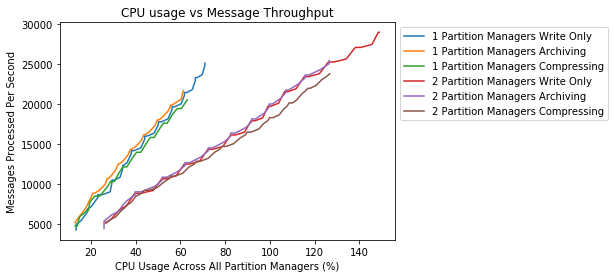

In [472]:
plt.tight_layout()
plt.title('CPU usage vs Message Throughput')
plt.xlabel('CPU Usage Across All Partition Managers (%)')
plt.ylabel('Messages Processed Per Second')
plotAverage(Write1,cpu,updates,"1 Partition Managers Write Only")
plotAverage(Archive1,cpu,updates,"1 Partition Managers Archiving")
plotAverage(compress1,cpu,updates,"1 Partition Managers Compressing")
plotAverage(Write2,cpu,updates,"2 Partition Managers Write Only")
plotAverage(Archive2,cpu,updates,"2 Partition Managers Archiving")
plotAverage(compress2,cpu,updates,"2 Partition Managers Compressing")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

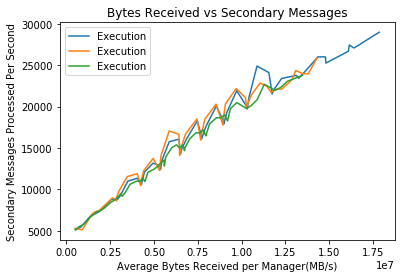

In [474]:
plt.tight_layout()
plt.title('Bytes Received vs Secondary Messages')
plt.xlabel('Average Bytes Received per Manager(MB/s)')
plt.ylabel('Secondary Messages Processed Per Second')
plotAverageSorted(Write2,networkReceived,updates,"Execution")
plotAverageSorted(Archive2,networkReceived,updates,"Execution")
plotAverageSorted(compress2,networkReceived,updates,"Execution")
plt.legend(loc='upper left') 